# Setup

In [1]:
# Imports

import polars as pl
import duckdb
import math
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
# Paths
project_dir = Path("/data/teamgdansk/mwaleron/carmen-analysis")

data_dir = project_dir.joinpath("data")
figures_dir = project_dir.joinpath("figures")
temp_dir = project_dir.joinpath("temp")

figures_gen_dir = figures_dir.joinpath("script-generated")
fig5panelb  = figures_gen_dir.joinpath("ENSG00000134086_genomic_view.pdf")
fig5panelw1 = figures_gen_dir.joinpath("high_population_example.pdf")
fig5panelw2 = figures_gen_dir.joinpath("mid_population_example.pdf")
fig5panelw3 = figures_gen_dir.joinpath("mid_population_example_2.pdf")
fig5panelw4 = figures_gen_dir.joinpath("mid_population_example_3.pdf")
fig5panelw5 = figures_gen_dir.joinpath("low_population_example.pdf")

figures_main_dir = figures_gen_dir.joinpath("main-panels")
figures_supp_dir = figures_gen_dir.joinpath("supplementary")

data_subs_dir = data_dir.joinpath("subsidiary-files")
data_pub_dir = data_dir.joinpath("to-be-published")

exon_regions_file = data_subs_dir.joinpath("exon_regions.parquet")

gendode_data_dir = data_subs_dir.joinpath("GENCODE")
gencodev39_stripped = gendode_data_dir.joinpath("gencode.v39.annotation.stripped.versions.parquet")

pogo_annotations_file = data_dir.joinpath("carmen-mapped-protein-annotations-pogo.parquet")

contig_scaffold_list_file = data_pub_dir.joinpath("scaff_all_expanded.tsv")
contig_peptide_list_file = data_pub_dir.joinpath("contig_unique_peptide_list.tsv")

main_samples_file_3 = data_subs_dir.joinpath("emilia_umap_with_ids.parquet")

All the file reads for this stage of analysis.

In [3]:
emilia_umap_with_ids = pl.read_parquet(main_samples_file_3)

In [4]:
contig_peptide_list = pl.read_csv(contig_peptide_list_file, separator="\t")
contig_scaffold_list = pl.read_csv(
    contig_scaffold_list_file,
    separator='\t')

In [5]:
gencodev39 = pl.scan_parquet(gencodev39_stripped)

In [6]:
pogo_annotations = pl.scan_parquet(pogo_annotations_file)

In [17]:
exon_regions = pl.scan_parquet(exon_regions_file)

# Panel b

In [8]:
def expand_exon_table(initial_table, gap_width):
    new_table = []
    current_pos = 0
    for row in initial_table.iter_rows(named=True):
        if current_pos == 0:
            current_pos = row["exon_ranges"][1]
            new_table.append({
                "adjusted_ranges" : [0, current_pos], 
                "diff":0
                })
        else:
            new_table.append({
                "adjusted_ranges" : [current_pos + gap_width, current_pos + gap_width + row["len"]],
                "diff" : row["exon_ranges"][0] - current_pos
                })
            current_pos = current_pos + gap_width + row["len"]

    corrected_table = initial_table.hstack(pl.DataFrame(new_table))
    return corrected_table

In [ ]:
## TODO: it's still a bit broken when the peptides / contigs don't align 

def visualize_gene3(ensg: str, gap_width: int):
    
    target = gencodev39.filter(pl.col("gene_id") == ensg)
    target_gene_record = target.filter(pl.col("feature")=="gene").collect()
    targetexons = target.filter(
            pl.col("feature") == "exon"
            ).with_columns((pl.col("end")-pl.col("start")).alias("len")
            ).select("start", "end", "len"
            ).sort("start", descending=False
            ).collect()
    targetpeptidelist = pogo_annotations.filter(
            pl.col("Gene_id") == ensg).collect()
    chr = target_gene_record["seqname"][0]
    exon_ranges = expand_exon_table(
        exon_regions.filter(
            pl.col("gene_id")==ensg
            ).with_columns(
                (pl.col("exon_ranges").list[1]-pl.col("exon_ranges").list[0]
                ).alias("len")
            ).collect(),
        # here needs be the spacing between exons, god i hate coming up with these numbers
        100
    )
    
    xlim_left = target_gene_record["start"][0]
    xlim_right = target_gene_record["end"][0]
    
    exontracks = []
    for exon in targetexons.iter_rows(named=True):
        added = False
        exon_start = 0
        exon_end = 0
        exon_len = 0
        for range in exon_ranges.iter_rows(named=True):
            if range["exon_ranges"][0] <= exon["start"] - xlim_left <= range["exon_ranges"][1]:
                exon_start = exon["start"] - range["diff"]
            if range["exon_ranges"][0] <= exon["end"] - xlim_left <= range["exon_ranges"][1]:
                exon_end = exon["end"] - range["diff"]
            
        if len(exontracks)==0:
            exontracks.append([exon["end"]])
            exontracks[0].append(( exon_start, exon["len"]))
        for exontrack in exontracks:
            if exon["start"] > exontrack[0]:
                exontrack.append(( exon_start, exon["len"]))
                exontrack[0] = exon["end"]
                added = True
                break
        if added == False:
            exontracks.append([exon["end"], ( exon_start, exon["len"])])
    
    peptidelist = pogo_annotations.filter(
        pl.col("Gene_id") == ensg
        ).unique("Peptide"
        ).with_columns(
            (pl.col("Gene_end")-pl.col("Gene_start")).alias("len")
        ).select("Gene_start","Gene_end","len"
        ).sort("Gene_start", descending=False).collect()
    tracks = []
    for peptide in peptidelist.iter_rows(named=True):
        added = False
        peptide_start = 0
        peptide_end = 0
        for range in exon_ranges.iter_rows(named=True):
            if range["exon_ranges"][0] <= peptide["Gene_start"] - xlim_left <= range["exon_ranges"][1]:
                peptide_start = peptide["Gene_start"] - range["diff"]
            if range["exon_ranges"][0] <= peptide["Gene_end"] - xlim_left <= range["exon_ranges"][1]:
                peptide_end = peptide["Gene_end"] - range["diff"]
        peptide_len = peptide_end - peptide_start
        
        if len(tracks)==0:
            tracks.append([peptide["Gene_end"]])
            tracks[0].append((peptide_start, peptide_len))
        for track in tracks:
            if peptide["Gene_start"] > track[0]:
                track.append((peptide_start, peptide_len))
                track[0] = peptide["Gene_end"]
                added = True
                break
        if added == False:
            tracks.append([peptide["Gene_end"], (peptide_start, peptide_len)])
    
    contigs = []
    contiglist = contig_scaffold_list.filter(
        (pl.col("gap_width") == 0) &
        (pl.col("Chromosome") == chr) &
            (
                (pl.col("Gene_start").is_between(xlim_left,xlim_right)) |
                (pl.col("Gene_end").is_between(xlim_left,xlim_right))
            )
        ).with_columns((pl.col("Gene_end")-pl.col("Gene_start")).alias("len")).select("Gene_start", "Gene_end", "len")
    for contig in contiglist.iter_rows(named=True):
        contig_start = 0
        contig_end = 0
        for range in exon_ranges.iter_rows(named=True):
            if range["exon_ranges"][0] <= contig["Gene_start"] - xlim_left <= range["exon_ranges"][1]:
                contig_start = contig["Gene_start"] - range["diff"]
            if range["exon_ranges"][0] <= contig["Gene_end"] - xlim_left <= range["exon_ranges"][1]:
                contig_end = contig["Gene_end"] - range["diff"]
        contig_len = contig_end - contig_start
        contigs.append((contig_start, contig_len))
    
    scaffolds = []
    scaffoldlist = contig_scaffold_list.filter(
        (pl.col("gap_width") == gap_width) &
        (pl.col("Chromosome") == chr) &
            (
                (pl.col("Gene_start").is_between(xlim_left,xlim_right)) |
                (pl.col("Gene_end").is_between(xlim_left,xlim_right))
            )
        ).with_columns((pl.col("Gene_end")-pl.col("Gene_start")).alias("len")).select("Gene_start", "Gene_end", "len")
    for scaffold in scaffoldlist.iter_rows(named=True):
        scaffold_start = 0
        scaffold_end = 0
        for range in exon_ranges.iter_rows(named=True):
            if range["exon_ranges"][0] <= scaffold["Gene_start"] - xlim_left <= range["exon_ranges"][1]:
                scaffold_start = scaffold["Gene_start"] - range["diff"]
            if range["exon_ranges"][0] <= scaffold["Gene_end"] - xlim_left <= range["exon_ranges"][1]:
                scaffold_end = scaffold["Gene_end"] - range["diff"]
        scaffold_len = scaffold_end - scaffold_start
        scaffolds.append((scaffold_start, scaffold_len))
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8,4)
    ax.ticklabel_format(style='plain')
    ax.set_xlim(left=xlim_left-1, right = xlim_right  - exon_ranges["diff"].max() +1)
    ax.tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
    ax.axis('off')
    exrep = 0
    for exontrack in exontracks:
        exontrack.pop(0)
        ax.broken_barh(exontrack,(0.1+(exrep*0.01), 0.005), facecolors='tab:blue')
        exrep +=1
    peprep = 0
    for peptrack in tracks:
        peptrack.pop(0)
        ax.broken_barh(peptrack,(0.11+(len(exontracks)*0.01)+(peprep*0.01),0.005), facecolors='tab:orange')
        peprep +=1
    
    ax.broken_barh(contigs,(0.1,0.02+(exrep*0.01)+(peprep*0.01)), facecolors='tab:pink', alpha=0.3)
    ax.broken_barh(scaffolds,(0.12+(exrep*0.01)+(peprep*0.01),0.01), facecolors='tab:green')
    
    plt.savefig(fig5panelb)

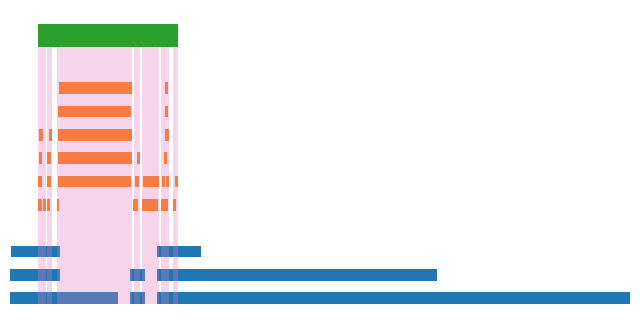

In [21]:
visualize_gene3("ENSG00000134086", 40)

# Panel f with the thing with ~~feathers~~ arrows for demonstrating how Promiscuity is calculated

In [22]:
midpop_example3 = contig_peptide_list.filter(pl.col("contig")=="C214661")

In [23]:
lowpop_example = contig_peptide_list.filter(pl.col("contig")=="C106200")

In [24]:
highpop_example = contig_peptide_list.filter(pl.col("contig")=="C122824")

In [25]:
midpop_example = contig_peptide_list.filter(pl.col("contig")=="C4271")

In [26]:
midpop_example2 = contig_peptide_list.filter(pl.col("contig")=="C186616")

In [27]:
def plot_motif_space_for_a_list_of_peptides(list_of_peptides, match_color = 'orange', mismatch_color= 'blue', minimum_match = 1, title_header = ""):
    from scipy.spatial import ConvexHull

    fig = plt.figure(figsize=(8,8))
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.rcParams["svg.fonttype"] = "none"
    emilia_umap_with_ids = pl.read_parquet(main_samples_file_3)
    motif_peptide_size = emilia_umap_with_ids\
                                .explode(
                                    "Peptides"
                                ).group_by(
                                    "Id"
                                ).count().rename({"count":"motif_size"})
    matchcount_per_motif =  emilia_umap_with_ids\
                                .explode(
                                    "Peptides"
                                ).with_columns(
                                    pl.col("Peptides").is_in(list_of_peptides).cast(pl.Int64())
                                ).group_by(
                                    "Id"
                                ).sum(
                                ).select(
                                    pl.col("Id"), pl.col("Peptides").alias("Number_of_matches")
                                ).join(motif_peptide_size, on="Id")
    plot_material = emilia_umap_with_ids\
                        .join(matchcount_per_motif, on="Id")
    if minimum_match >= 1:
        matches = plot_material.filter(pl.col("Number_of_matches")>=minimum_match)
        mismatches = plot_material.filter(pl.col("Number_of_matches")<minimum_match)
    elif 1.0 > minimum_match > 0.0:
        matches = plot_material.filter(pl.col("Number_of_matches")>=minimum_match * pl.col("motif_size"))
        mismatches = plot_material.filter(pl.col("Number_of_matches")<minimum_match * pl.col("motif_size"))
    else:
        return "That aint a correct minimal match numer or fraction"
    
    xallcen = (emilia_umap_with_ids["x"].min() + emilia_umap_with_ids["x"].max() )/2
    yallcen = (emilia_umap_with_ids["y"].min() + emilia_umap_with_ids["y"].max() )/2
    match_x = matches["x"].sum() / matches["x"].len()
    match_y = matches["y"].sum() / matches["y"].len()
    vlen = math.sqrt((match_x - xallcen) ** 2 + (match_y - yallcen) ** 2)
    listscore = len(matches) / math.sqrt(1+vlen)

    fig.suptitle(f"$ \\frac{{ {len(matches)} }}{{ \\sqrt{{ 1+{vlen} }} }}$")
    ax1 = plt.subplot(111)
    ax1.scatter(mismatches["x"], mismatches["y"], c=mismatch_color, s=4)
    ax1.scatter(matches["x"], matches["y"], c=match_color, s=4)
    ax1.set_title(f"{len(list_of_peptides)} unique peptides\n{listscore:.2f} population coverage score")
    ax1.set_xlabel("UMAP_1")
    ax1.set_ylabel("UMAP_2")
    ax1.set_xticklabels("")
    ax1.set_yticklabels("")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.axvline(xallcen)
    ax1.axhline(yallcen)
    
    ch = matches.select(pl.col("x"), pl.col("y")).to_numpy()
    hull = ConvexHull(ch)
    for simplex in hull.simplices:
        ax1.plot(matches[simplex]["x"],matches[simplex]["y"], c='tab:red')
    ax1.annotate(
        "",
        xy=(match_x,match_y),
        xytext=(xallcen,yallcen),
        arrowprops=dict(
            arrowstyle="->",
            patchA=None,
            patchB=None,
            shrinkA=0,
            shrinkB=0,
            linewidth=3,
            color="tab:red"
        ))
    fig.show()
    return fig

/tmp/ipykernel_2135365/2577873287.py:9: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\


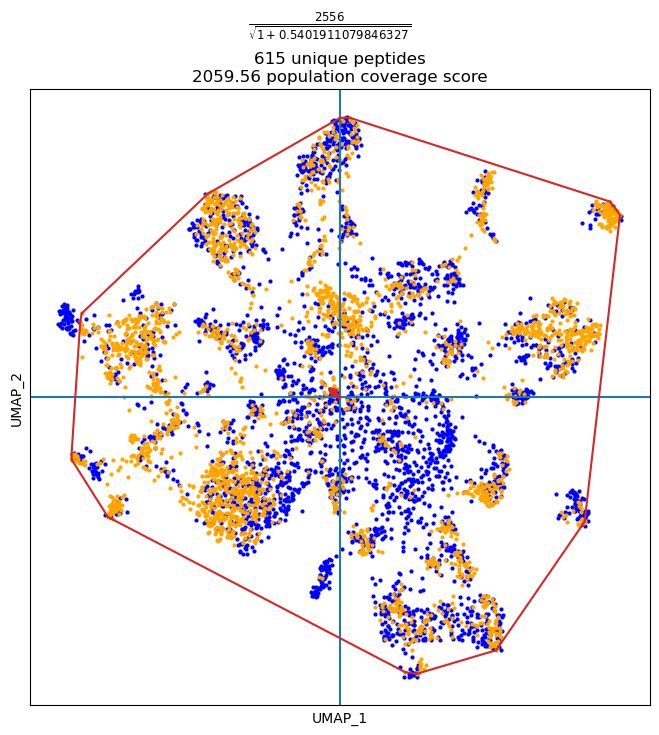

In [28]:
plot_motif_space_for_a_list_of_peptides(highpop_example["pep_list"].str.split(",")[0]).savefig(fig5panelw1)

/tmp/ipykernel_1356274/408427436.py:9: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\


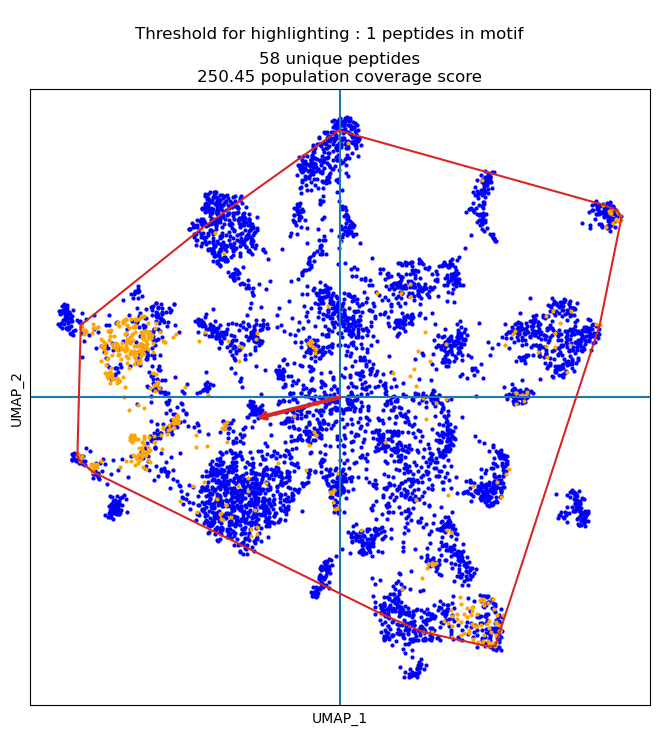

In [ ]:
plot_motif_space_for_a_list_of_peptides(midpop_example["pep_list"].str.split(",")[0]).savefig(fig5panelw2)

/tmp/ipykernel_1356274/408427436.py:9: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\


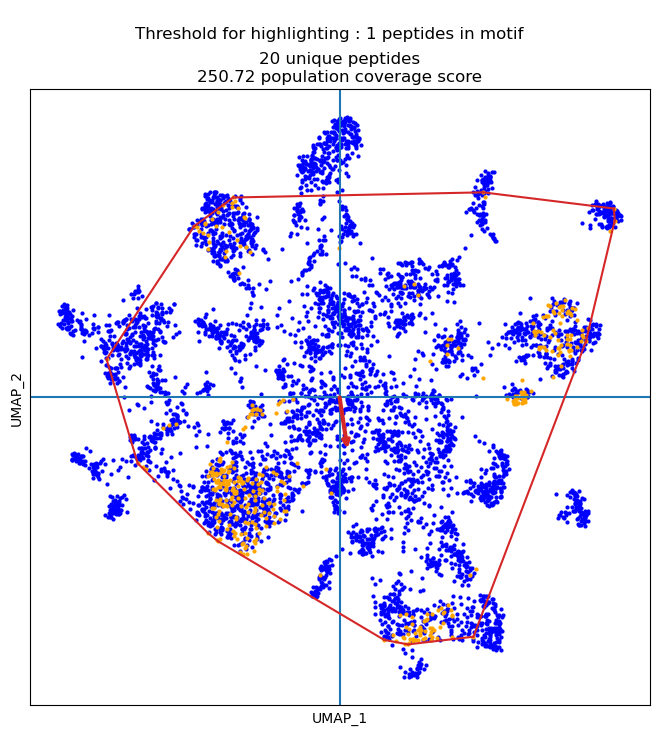

In [ ]:
plot_motif_space_for_a_list_of_peptides(midpop_example2["pep_list"].str.split(",")[0]).savefig(fig5panelw3)

/tmp/ipykernel_1356274/408427436.py:9: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\


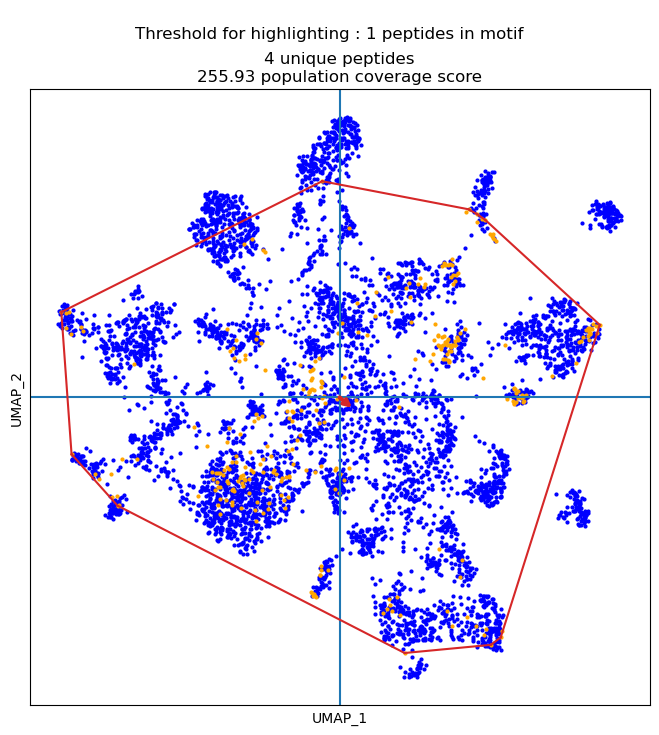

In [ ]:
plot_motif_space_for_a_list_of_peptides(midpop_example3["pep_list"].str.split(",")[0]).savefig(fig5panelw4)

/tmp/ipykernel_1356274/408427436.py:9: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\


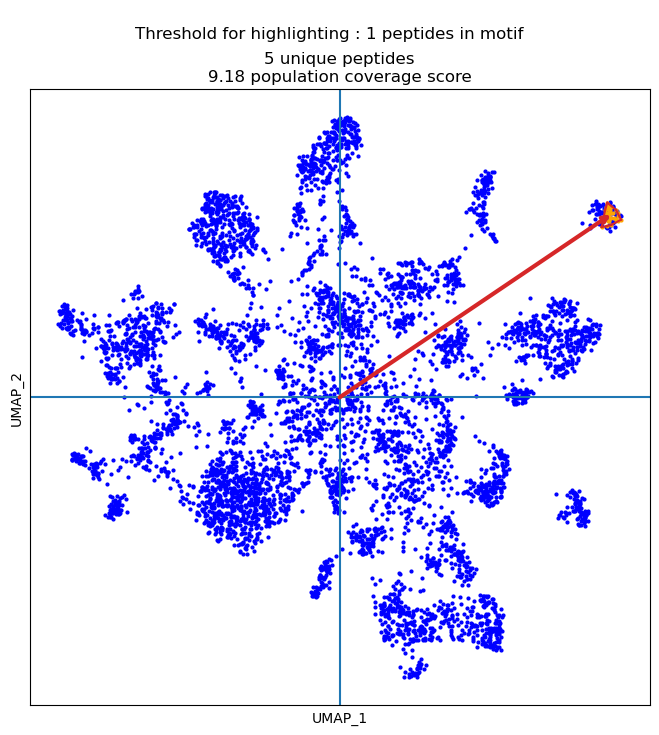

In [ ]:
plot_motif_space_for_a_list_of_peptides(lowpop_example["pep_list"].str.split(",")[0]).savefig(fig5panelw5)

# Final Cleanup

This is to clean up and delete all additional files and directories created throughout the analysis.

**Do not run the second cell unless you want to end your work here or start over.**

In [ ]:
# This is a safety code

raise KeyboardInterrupt("Are you sure you want to run the cell below?")

In [ ]:
# Run this cell to do a clean-up

temp_dir.joinpath(f"trashpanda{i}.parquet").unlink(missing_ok=True)

shutil.rmtree(data_subs_dir)
shutil.rmtree(figures_gen_dir)
shutil.rmtree(temp_dir)

In [ ]:
print("\n".join([f"{f}" for f in ext_data_files]))